In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional

import constants

In [2]:
DEV_MODE = True

ukbb_data_file = "small_ukbiobank.csv" if DEV_MODE else "ukbiobank.csv"
ukbb_data_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, ukbb_data_file)

ukbb_index_html_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, "ukbiobank.html")
ukbb_index_csv_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, "ukbiobank_index.csv")

In [3]:
# Plot helpers
def titleize(label: str) -> str:
    """"""
    return label.replace("_", " ").title()


def add_plt_labels(ax, x: str, y: str, title: Optional[str] = None, **kwargs) -> None:
    ax.set_xlabel(titleize(x))
    ax.set_ylabel(titleize(y))
    if title:
        ax.set_title(titleize(title))

# Data Index

In [17]:
if os.path.exists(ukbb_index_csv_path):
    ukbb_index = pd.read_csv(ukbb_index_csv_path)
else:
    ukbb_html = bsoup(open(ukbb_index_html_path,'r').read())
    ukbb_index_html = ukbb_html.find_all("table")[1]
    ukbb_index = pd.read_html(str(ukbb_index_html))[0]
    ukbb_index.columns = [col.lower() for col in ukbb_index.columns]
    ukbb_index.to_csv(ukbb_index_csv_path, index=False)

ukbb_index["data_coding"] = ukbb_index["description"].apply(lambda desc: desc.split("Uses")[1] if "Uses" in desc else "")
ukbb_index["description"] = ukbb_index["description"].apply(lambda desc: desc.split("Uses")[0])


def split_data_coding(data_coding: str):
    if len(data_coding) == 0:
        return [None, None, None, None]

    _, data_coding, _, n_members, data_type, _, _, _, pretype, type_ = data_coding.lower().split()
    return [int(data_coding), int(n_members), data_type, pretype + "_" + type_.rstrip(".")]


data_info = pd.DataFrame(data=np.array(ukbb_index["data_coding"].apply(split_data_coding).to_list()),
                         columns=["data_code", "data_n_members", "data_type", "data_structure"])
ukbb_index = pd.concat([ukbb_index, data_info], axis=1).drop(["data_coding"], axis=1)

In [30]:
outlier_udi_lookup = pd.read_csv("resources/outlier_udi_lookup.csv", sep=",")
core_udi_lookup = pd.read_csv("resources/core_udi_lookup.csv", sep=",")
partial_udi_lookup = pd.concat([core_udi_lookup, outlier_udi_lookup])

partial_labeled_udis = partial_udi_lookup.loc[partial_udi_lookup["name"] != "_"]
partial_udi_to_name_map = dict(zip(partial_labeled_udis["udi"], partial_labeled_udis["name"]))

names = []
for udi in ukbb_index["udi"]:
    if "-" not in udi or udi.endswith("-0.0"):
        names.append(partial_udi_to_name_map.get(udi, None))
    else:
        udi_stem, udi_modifier = udi.split("-")
        new_name = None
        
        if udi_stem + "-0.0" in partial_udi_to_name_map:
            names.append(f"{partial_udi_to_name_map[udi_stem + '-0.0']}_{udi_modifier}")
        elif udi_stem + "-0.1" in partial_udi_to_name_map:
            names.append(f"{partial_udi_to_name_map[udi_stem + '-0.1']}_{udi_modifier}")
        else:
            names.append(None)

ukbb_index["name"] = names
udi_to_name_map = dict(zip(ukbb_index["udi"], ukbb_index["name"]))
name_to_udi_map = dict(zip(ukbb_index["name"], ukbb_index["udi"]))

ukbb_index = ukbb_index[['column', 'udi', 'count', "type", 'counts', 'frequency', "name",
                         'description', 'data_code', 'data_n_members', 'data_type', 'data_structure']]

In [31]:
def get_udi(name):
    if isinstance(name, str):
        return name_to_udi_map.get(name, name)

    return [get_udi(name_i) for name_i in name]


def get_name_from_udi(udi):
    if isinstance(udi, str):
        return udi_to_name_map.get(udi, udi)

    return [get_name_from_udi(udi_i) for udi_i in udi]


def udi_wrapper(function, *args, **kwargs) -> Any:
    """"""
    args = {get_udi(arg) for arg in args}
    kwargs = {key: get_udi(value) if isinstance(value, str) else value for key, value in kwargs.items()}
    return function(*args, **kwargs)


def relevant_feature_search(ukbb_index: pd.DataFrame, term: str) -> pd.DataFrame:
    """"""
    modified_names = ukbb_index["name"].apply(lambda s: s.replace("_", " ") + " " if s else "")
    found_indices = [i for (i, description) in enumerate(modified_names + ukbb_index["description"])
                     if fuzz.partial_ratio(description.lower(), term.lower()) > 95]
    return ukbb_index.iloc[found_indices]

In [32]:
ukbb_index.head()

,column,udi,count,type,counts,frequency,name,description,data_code,data_n_members,data_type,data_structure
0,0,eid,502543,Sequence,9999,1.000000,eid,Encoded anonymised participant ID,None,None,None,None
1,1,23-0.0,456606,Categorical (single),9056,0.905691,spirometry_method,Spirometry method,100270,5,integer-valued,simple_list
2,2,23-1.0,18135,Categorical (single),363,0.036304,spirometry_method_1.0,Spirometry method,100270,5,integer-valued,simple_list
3,3,23-2.0,26790,Categorical (single),528,0.052805,spirometry_method_2.0,Spirometry method,100270,5,integer-valued,simple_list
4,4,31-0.0,502543,Categorical (single),9999,1.000000,sex,Sex,9,2,integer-valued,simple_list


In [33]:
relevant_feature_search(ukbb_index, "HTN")

,column,udi,count,type,counts,frequency,name,description,data_code,data_n_members,data_type,data_structure
760,760,2966-0.0,134649,Integer,2613,0.261326,HTN_dx_age,Age high blood pressure diagnosed,100291,2,integer-valued,simple_list
761,761,2966-1.0,5856,Integer,116,0.011601,HTN_dx_age_1.0,Age high blood pressure diagnosed,100291,2,integer-valued,simple_list
762,762,2966-2.0,7559,Integer,138,0.013801,HTN_dx_age_2.0,Age high blood pressure diagnosed,100291,2,integer-valued,simple_list
1309,1309,6153-0.0,270871,Categorical (multiple),5376,0.537654,medications_HLD_HTN_diabetes_HRT,"Medication for cholesterol, blood pressure, di...",100626,8,integer-valued,simple_list
1310,1310,6153-0.1,24598,Categorical (multiple),489,0.048905,medications_HLD_HTN_diabetes_HRT_0.1,"Medication for cholesterol, blood pressure, di...",100626,8,integer-valued,simple_list
1311,1311,6153-0.2,2414,Categorical (multiple),56,0.005601,medications_HLD_HTN_diabetes_HRT_0.2,"Medication for cholesterol, blood pressure, di...",100626,8,integer-valued,simple_list
1312,1312,6153-0.3,93,Categorical (multiple),3,0.000300,medications_HLD_HTN_diabetes_HRT_0.3,"Medication for cholesterol, blood pressure, di...",100626,8,integer-valued,simple_list
1313,1313,6153-1.0,10402,Categorical (multiple),214,0.021402,medications_HLD_HTN_diabetes_HRT_1.0,"Medication for cholesterol, blood pressure, di...",100626,8,integer-valued,simple_list
1314,1314,6153-1.1,1076,Categorical (multiple),22,0.002200,medications_HLD_HTN_diabetes_HRT_1.1,"Medication for cholesterol, blood pressure, di...",100626,8,integer-valued,simple_list
1315,1315,6153-1.2,92,Categorical (multiple),2,0.000200,medications_HLD_HTN_diabetes_HRT_1.2,"Medication for cholesterol, blood pressure, di...",100626,8,integer-valued,simple_list


# Load BioBank Data

In [22]:
ukbb_data = pd.read_csv(ukbb_data_path, low_memory=False)
ukbb_data.head()

,eid,23-0.0,23-1.0,23-2.0,31-0.0,34-0.0,35-0.0,35-1.0,35-2.0,36-0.0,...,41240-0.0,41241-0.0,41247-0.0,41247-0.1,41247-0.2,41247-0.3,41247-0.4,41247-0.5,41247-0.6,41252-0.0
0,1000015,0.0,NaN,NaN,1,1963,1.0,NaN,NaN,157.0,...,2.0,3.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,5.0
1,1000027,0.0,NaN,NaN,0,1956,1.0,NaN,NaN,3157.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1000039,NaN,NaN,NaN,0,1948,1.0,NaN,NaN,1048.0,...,13.0,15.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,19.0
3,1000040,0.0,NaN,NaN,1,1947,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,1000053,0.0,NaN,0.0,0,1962,1.0,NaN,1.0,162.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,column,udi,count,type,description,data_code,data_n_members,data_type,data_structure,name,counts,frequency
0,0,eid,502543,Sequence,Encoded anonymised participant ID,None,None,None,None,eid,9999,1.000000
1,1,23-0.0,456606,Categorical (single),Spirometry method,100270,5,integer-valued,simple_list,spirometry_method,9056,0.905691
2,2,23-1.0,18135,Categorical (single),Spirometry method,100270,5,integer-valued,simple_list,spirometry_method_1.0,363,0.036304
3,3,23-2.0,26790,Categorical (single),Spirometry method,100270,5,integer-valued,simple_list,spirometry_method_2.0,528,0.052805
4,4,31-0.0,502543,Categorical (single),Sex,9,2,integer-valued,simple_list,sex,9999,1.000000
5,5,34-0.0,502543,Integer,Year of birth,None,None,None,None,birth_year,9999,1.000000
6,6,35-0.0,501328,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted,9978,0.997900
7,7,35-1.0,20337,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted_1.0,412,0.041204
8,8,35-2.0,29389,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted_2.0,575,0.057506
9,9,36-0.0,497907,Text,Blood pressure device ID,None,None,None,None,bp_device,9907,0.990799


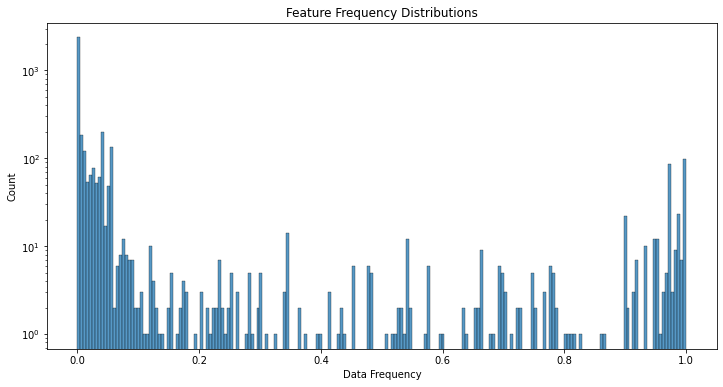

,column,udi,count,type,description,data_code,data_n_members,data_type,data_structure,name,counts,frequency
0,0,eid,502543,Sequence,Encoded anonymised participant ID,None,None,None,None,eid,9999,1.000000
4,4,31-0.0,502543,Categorical (single),Sex,9,2,integer-valued,simple_list,sex,9999,1.000000
5,5,34-0.0,502543,Integer,Year of birth,None,None,None,None,birth_year,9999,1.000000
6,6,35-0.0,501328,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted,9978,0.997900
9,9,36-0.0,497907,Text,Blood pressure device ID,None,None,None,None,bp_device,9907,0.990799
...,...,...,...,...,...,...,...,...,...,...,...,...
2718,2718,20117-0.0,501646,Categorical (single),Alcohol drinker status,90,4,integer-valued,simple_list,alcohol_use_status,9969,0.997000
2734,2734,20160-0.0,499657,Categorical (single),Ever smoked,7,2,integer-valued,simple_list,tobacco_smoking_ever,9927,0.992799
2743,2743,21000-0.0,501645,Categorical (single),Ethnic background,1001,22,integer-valued,hierarchical_tree,ethnic_background,9969,0.997000
2746,2746,21003-0.0,502543,Integer,Age when attended assessment centre,None,None,None,None,assessment_age,9999,1.000000


In [23]:
ukbb_index["counts"] = np.array(ukbb_data.count().tolist())
ukbb_index["frequency"] = ukbb_index["counts"] / len(ukbb_data)
display(ukbb_index.head(10))

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(ukbb_index["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig("cover_plots/feature_frequency_distribution.png")

display(ukbb_index.query("frequency > .99"))

# actual EDA

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"
udi_wrapper(sns.kdeplot, data=ukbb_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
ax = udi_wrapper(sns.kdeplot, data=ukbb_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x="tobacco_smoking_current_start_age", hue="sex",  ax=ax)

In [ ]:

x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")